# Tutorial on PnP-LADMM

#### Imports

In [15]:
import os
import tqdm
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.utils_pnp import get_metrics, get_metrics_bis
import utils.utils_image as util
import utils.utils_sisr as sisr

from models.model_pnp_approximate_admm import PnP_approx_ADMM
from models.model_pnp_ista import PnP_ISTA
from models.model_pnp_ladmm import PnP_linearized_ADMM

In [16]:
# !wget -O 'custom_blur_centered.zip' "https://onedrive.live.com/download?cid=C452783A8B2F31F6&resid=C452783A8B2F31F6%21140808&authkey=AGekosneMSy-ql8"
# !unzip custom_blur_centered.zip
# !mv custom_blur_centered.mat kernels/
# !mv drunet_color.pth model_zoo/
# !rm custom_blur_centered.zip
# !rm -r __MACOSX/

In [17]:
# !wget -O coco.zip "https://onedrive.live.com/download?cid=C452783A8B2F31F6&resid=C452783A8B2F31F6%21140812&authkey=APxbXRrYfPHHo7Y"
# !unzip coco.zip
# !mkdir datasets
# !mkdir datasets/COCO
# !mv instances_val2014.json datasets/COCO/
# !mkdir datasets/COCO/val2014
# !mv reduced_coco/* datasets/COCO/val2014
# !rm -R reduced_coco
# !rm coco.zip


#### Data-loading

In [18]:
from data.dataset_multiblur import Dataset

ROOT = './'

opt_data = { "phase": "train"
          , "dataset_type": "multiblur"
          , "dataroot_H": ROOT + "/datasets/COCO/val2014"
          , "dataroot_L": None
          , "H_size": 128
          , "use_flip": True
          , "use_rot": True
          , "scales": [1]
          , "sigma": [2, 3]
          , "sigma_test": 15
          , "n_channels": 3
          , "dataloader_shuffle": True
          , "dataloader_num_workers": 16
          , "dataloader_batch_size": 16
          , "motion_blur": True

          , "coco_annotation_path": ROOT + "/datasets/COCO/instances_val2014.json"}

data = Dataset(opt_data)

from torch.utils.data import DataLoader
loader = DataLoader(data, batch_size=1)


loading annotations into memory...
Done (t=8.82s)
creating index...
index created!


#### Creation of the model

In [50]:
etas = np.linspace(0,1,100)
PSNR_result_means = []
for eta in etas:
    opt_pnp_ista = {'device': 'cuda',
                         'eta': eta,
                         'sigma_d': 20/255,
        #                  'Lx': 1 / ((20 / 255)**2), 
                         'n_iter': 40,
                         'path_denoiser': 'model_zoo/drunet_color.pth'}

    pnp_ista = PnP_ISTA(opt_pnp_ista)
    i = 0
    result_mean = 0
    for sample in loader:
        i += 1
        # run model
    #     pnp_ladmm.feed_data(sample)
    #     x_admm, x_list_admm, time_list_admm = pnp_ladmm.run()

        

        pnp_ista.feed_data(sample)
        x_ista, x_list_ista, time_list_ista = pnp_ista.run()

    #     psnr_admm = calculate_psnr(util.tensor2uint(x_admm), util.tensor2uint(sample['H']))
        psnr_ista = calculate_psnr(util.tensor2uint(x_ista), util.tensor2uint(sample['H']))
        result_mean += psnr_ista
        if i >= iter_max:
            break

    result_mean = result_mean / i
    PSNR_result_means.append(result_mean)
    print("PSNR with ista : ", result_mean)


PSNR with ista :  21.390936163382243
PSNR with ista :  21.337060367767638
PSNR with ista :  22.24759179208484
PSNR with ista :  23.77586819268512
PSNR with ista :  21.234465048698443
PSNR with ista :  24.95838909199023
PSNR with ista :  21.941396733159593
PSNR with ista :  22.4670623535554
PSNR with ista :  23.435190683657403
PSNR with ista :  25.293394369665894
PSNR with ista :  25.18559806164859
PSNR with ista :  23.703743188988547
PSNR with ista :  24.639111968836268
PSNR with ista :  25.07000732887753
PSNR with ista :  24.059252096343577
PSNR with ista :  24.46294817179349
PSNR with ista :  24.261027121818646
PSNR with ista :  25.910228085172925
PSNR with ista :  24.778804963358503
PSNR with ista :  23.924460231209768
PSNR with ista :  24.94780732954974
PSNR with ista :  23.849517342180924
PSNR with ista :  23.7720381523615
PSNR with ista :  24.831917177205902
PSNR with ista :  25.221508930492423
PSNR with ista :  24.29601113632095
PSNR with ista :  25.33848741573576
PSNR with ista

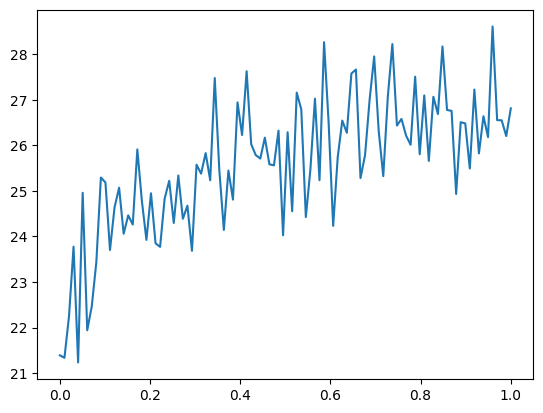

In [52]:
plt.plot(etas,PSNR_result_means)

In [53]:
print(etas[np.argmax(PSNR_result_means)])

0.9595959595959597


In [47]:
len(loader)

40473

In [19]:
opt_pnp_ladmm = {'device': 'cuda',
                 'lamb': 1,
                 'sigma_d': 20/255,
                 'Lx': 1 / ((20 / 255)**2), 
                 'n_iter': 100,
                 'path_denoiser': 'model_zoo/drunet_color.pth'}

pnp_ladmm = PnP_linearized_ADMM(opt_pnp_ladmm)

opt_pnp_ista = {'device': 'cuda',
                 'eta': 0.95,
                 'sigma_d': 20/255,
#                  'Lx': 1 / ((20 / 255)**2), 
                 'n_iter': 200,
                 'path_denoiser': 'model_zoo/drunet_color.pth'}

pnp_ista = PnP_ISTA(opt_pnp_ista)


#### Run model

In [20]:
from utils.utils_image import calculate_psnr
import time

PSNR with ista :  26.272733643233476  in :  0.001196972
PSNR with Ladmm :  28.162731125524267  in :  0.007975044
addmm ista ratio :  5.66
PSNR with ista :  32.8356768313509  in :  0.00107768
PSNR with Ladmm :  33.86547060341932  in :  0.002085657
addmm ista ratio :  0.935


/tmp/ipykernel_2165/3381618297.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(141)
/tmp/ipykernel_2165/3381618297.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(142)
/tmp/ipykernel_2165/3381618297.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and 

PSNR with ista :  23.3706441989574  in :  0.0010693
PSNR with Ladmm :  24.912292940396664  in :  0.001841765
addmm ista ratio :  0.722
PSNR with ista :  31.742418770187065  in :  0.001083337
PSNR with Ladmm :  31.65968477954353  in :  0.00211974
addmm ista ratio :  0.957
PSNR with ista :  30.08873576813228  in :  0.001070207
PSNR with Ladmm :  33.43994581704642  in :  0.002327175
addmm ista ratio :  1.17
PSNR with ista :  22.012984471008956  in :  0.001084944
PSNR with Ladmm :  24.481303564464763  in :  0.001844209
addmm ista ratio :  0.7
PSNR with ista :  25.77911348661611  in :  0.000891828
PSNR with Ladmm :  28.037670720217093  in :  0.001691951
addmm ista ratio :  0.897
PSNR with ista :  27.572908643106008  in :  0.001079635
PSNR with Ladmm :  29.711634506092828  in :  0.002525948
addmm ista ratio :  1.34
PSNR with ista :  34.3437712411787  in :  0.001107573
PSNR with Ladmm :  35.47985452825878  in :  0.00224944
addmm ista ratio :  1.03
PSNR with ista :  27.07672266925379  in :  0.

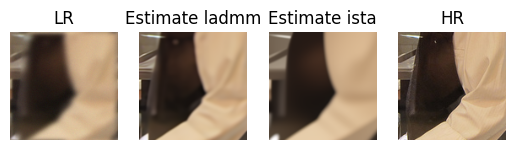

In [21]:
i = 0
iter_max = 10


for sample in loader:
    i += 1
    # run model
    pnp_ladmm.feed_data(sample)
    x_admm, x_list_admm, time_list_admm = pnp_ladmm.run()
    
    pnp_ista.feed_data(sample)
    x_ista, x_list_ista, time_list_ista = pnp_ista.run()
    
    begin = time.perf_counter()
    psnr_admm = calculate_psnr(util.tensor2uint(x_admm), util.tensor2uint(sample['H']))
    end = time.perf_counter()
    admm_time = end - begin
    begin = time.perf_counter()
    psnr_ista = calculate_psnr(util.tensor2uint(x_ista), util.tensor2uint(sample['H']))
    end = time.perf_counter()
    ista_time = end - begin
    
    print("PSNR with ista : ", psnr_ista, " in : ", '{0:.8g}'.format(ista_time))
    print("PSNR with Ladmm : ", psnr_admm, " in : ", '{0:.8g}'.format(admm_time ))
    print("addmm ista ratio : ", '{0:.3g}'.format((admm_time - ista_time)/ista_time))

    #plot
    plt.subplot(141)
    plt.imshow(util.tensor2uint(sample['L']))
    plt.axis('off')
    plt.title('LR')
    plt.subplot(142)
    plt.imshow(util.tensor2uint(x_admm))
    plt.axis('off')
    plt.title('Estimate ladmm')
    plt.subplot(143)
    plt.imshow(util.tensor2uint(x_ista))
    plt.axis('off')
    plt.title('Estimate ista')
    plt.subplot(144)
    plt.imshow(util.tensor2uint(sample['H']))
    plt.axis('off')
    plt.title('HR')

    # Stop after n_iter
    if i >= iter_max:
        break

In [22]:
sample['L'].shape

torch.Size([1, 3, 128, 128])

In [23]:
from models.model_pnp_ista import PnP_ISTA

In [24]:
fig.set_figheight

NameError: name 'fig' is not defined

In [25]:
opt_pnp_ista = {'device': 'cuda',
                 'eta': 1,
                 'sigma_d': 20/255,
#                  'Lx': 1 / ((20 / 255)**2), 
                 'n_iter': 40,
                 'path_denoiser': 'model_zoo/drunet_color.pth'}

pnp_ista = PnP_ISTA(opt_pnp_ista)

Text(0.5, 1.0, 'HR')

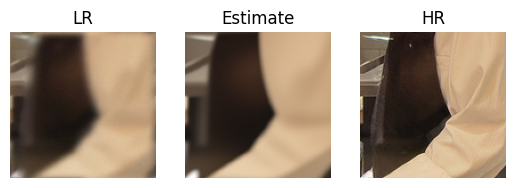

In [26]:
i = 0
iter_max = 1

# for sample in loader:
i += 1
# run model
pnp_ista.feed_data(sample)
x, x_list, time_list = pnp_ista.run()

#plot
plt.subplot(131)
plt.imshow(util.tensor2uint(sample['L']))
plt.axis('off')
plt.title('LR')
plt.subplot(132)
plt.imshow(util.tensor2uint(x))
plt.axis('off')
plt.title('Estimate')
plt.subplot(133)
plt.imshow(util.tensor2uint(sample['H']))
plt.axis('off')
plt.title('HR')

# Stop after n_iter
# if i >= iter_max:
#     break

In [28]:
x.shape

torch.Size([1, 3, 128, 128])

In [ ]:
def calculate_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 255]
    #img1 = img1.squeeze()
    #img2 = img2.squeeze()
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    h, w = img1.shape[:2]
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [30]:
import hdf5storage
data = hdf5storage.loadmat('kernels/custom_blur_centered.mat')

In [31]:
np.shape(data["kernels"])

(1, 100588)

In [32]:
128*128

16384